# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

<div class="alert alert-block alert-success">
<b>✔️ Комментарий ревьюера: </b> Хорошая работа. Удачно подобраны визуализации. Проведён подробный анализ данных. Использованы различные модели машинного обучения и проведено их сравнение. Увидел выводы к каждому этапу работы. Но есть маленькие недочёты. Их нужно исправить. 
Осталось совсем чуть-чуть. Всегда готов ответить на твои вопросы. Насчёт линейной регрессии не переживай - это нормальный для неё результат. Датасет сложный, простые линейные модели не справляются
</div>

## Подготовка данных

In [1]:
#импорты
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import r2_score
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
import lightgbm as lgbm
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder 
from sklearn.model_selection import cross_val_score

import time

In [2]:
data =  pd.read_csv('/datasets/autos.csv')
data.head()


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [4]:
data.corr()['Price']

Price                1.000000
RegistrationYear     0.026916
Power                0.158872
Kilometer           -0.333199
RegistrationMonth    0.110581
NumberOfPictures          NaN
PostalCode           0.076055
Name: Price, dtype: float64

### Пропуски

In [5]:
#  количество пропусков

pd.DataFrame(data.isna().sum(), columns = ['пропусков']).style.background_gradient()

,пропусков
DateCrawled,0
Price,0
VehicleType,37490
RegistrationYear,0
Gearbox,19833
Power,0
Model,19705
Kilometer,0
RegistrationMonth,0
FuelType,32895


<div class="alert alert-block alert-success">
<b>✔️ Комментарий ревьюера:</b> Да, спасибо за оформление
</div>

In [6]:
#очень большое количество пропусков - надо заменять
data['VehicleType'].unique()

array([nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

In [7]:
#заменяю пропуски на unknown
data.fillna({'VehicleType':'unknown'}, inplace=True)
data.VehicleType.value_counts()

sedan          91457
small          79831
wagon          65166
unknown        37490
bus            28775
convertible    20203
coupe          16163
suv            11996
other           3288
Name: VehicleType, dtype: int64

In [8]:
data.VehicleType.isna().sum()


0

In [9]:
#думаю заменить на ручную
data['Gearbox'].unique()

array(['manual', 'auto', nan], dtype=object)

In [10]:
data.fillna({'Gearbox':'manual'}, inplace=True)
data.Gearbox.value_counts()

manual    288084
auto       66285
Name: Gearbox, dtype: int64

In [11]:
data['Model'].unique()

array(['golf', nan, 'grand', 'fabia', '3er', '2_reihe', 'other', 'c_max',
       '3_reihe', 'passat', 'navara', 'ka', 'polo', 'twingo', 'a_klasse',
       'scirocco', '5er', 'meriva', 'arosa', 'c4', 'civic', 'transporter',
       'punto', 'e_klasse', 'clio', 'kadett', 'kangoo', 'corsa', 'one',
       'fortwo', '1er', 'b_klasse', 'signum', 'astra', 'a8', 'jetta',
       'fiesta', 'c_klasse', 'micra', 'vito', 'sprinter', '156', 'escort',
       'forester', 'xc_reihe', 'scenic', 'a4', 'a1', 'insignia', 'combo',
       'focus', 'tt', 'a6', 'jazz', 'omega', 'slk', '7er', '80', '147',
       '100', 'z_reihe', 'sportage', 'sorento', 'v40', 'ibiza', 'mustang',
       'eos', 'touran', 'getz', 'a3', 'almera', 'megane', 'lupo', 'r19',
       'zafira', 'caddy', 'mondeo', 'cordoba', 'colt', 'impreza',
       'vectra', 'berlingo', 'tiguan', 'i_reihe', 'espace', 'sharan',
       '6_reihe', 'panda', 'up', 'seicento', 'ceed', '5_reihe', 'yeti',
       'octavia', 'mii', 'rx_reihe', '6er', 'modus', 'fox'

In [12]:
#заменю на unknown
data.fillna({'Model':'other'}, inplace=True)
data.Model.value_counts()

other                 44126
golf                  29232
3er                   19761
polo                  13066
corsa                 12570
                      ...  
serie_2                   8
rangerover                4
serie_3                   4
range_rover_evoque        2
serie_1                   2
Name: Model, Length: 250, dtype: int64

<div class="alert alert-block alert-warning">
<b>⚠️ Комментарий ревьюера: </b> Предлагаю заменить на other. Такое значение уже есть в датасете
</div>

<div class="alert alert-block alert-success">
<b>✔️ Комментарий ревьюера v2: </b> 👍
</div>

In [13]:
data['FuelType'].unique()

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

In [14]:
data.FuelType.value_counts()

petrol      216352
gasoline     98720
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: FuelType, dtype: int64

In [15]:
#заменю на petrol 
data.fillna({'FuelType':'other'}, inplace=True)
data.FuelType.value_counts()

petrol      216352
gasoline     98720
other        33099
lpg           5310
cng            565
hybrid         233
electric        90
Name: FuelType, dtype: int64

<div class="alert alert-block alert-warning">
<b>⚠️ Комментарий ревьюера: </b> Предлагаю заменить на other. Такое значение уже есть в датасете
</div>

<div class="alert alert-block alert-success">
<b>✔️ Комментарий ревьюера v2: </b> 👍
</div>

In [16]:
data['Repaired'].unique()

array([nan, 'yes', 'no'], dtype=object)

In [17]:
#заменю на unknown (или лучше yes?)
data.fillna({'Repaired':'unknown'}, inplace=True)
data.Repaired.value_counts()

no         247161
unknown     71154
yes         36054
Name: Repaired, dtype: int64

In [18]:
pd.DataFrame(data.isna().sum(), columns = ['пропусков']).style.background_gradient()

,пропусков
DateCrawled,0
Price,0
VehicleType,0
RegistrationYear,0
Gearbox,0
Power,0
Model,0
Kilometer,0
RegistrationMonth,0
FuelType,0


### Дубликаты

In [19]:
data.duplicated().sum()



4

In [20]:
data = data.drop_duplicates()
data.duplicated().sum()

0

### Проверю остальные признаки

In [21]:
#удалю лишние признаки
data1 = data.copy()
data = data.drop(["DateCrawled","DateCreated","LastSeen","NumberOfPictures","PostalCode"],axis = 1)

<div class="alert alert-block alert-success">
<b>✔️ Комментарий ревьюера: </b> Согласен, можно удалить
</div>

In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354365 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              354365 non-null  int64 
 1   VehicleType        354365 non-null  object
 2   RegistrationYear   354365 non-null  int64 
 3   Gearbox            354365 non-null  object
 4   Power              354365 non-null  int64 
 5   Model              354365 non-null  object
 6   Kilometer          354365 non-null  int64 
 7   RegistrationMonth  354365 non-null  int64 
 8   FuelType           354365 non-null  object
 9   Brand              354365 non-null  object
 10  Repaired           354365 non-null  object
dtypes: int64(5), object(6)
memory usage: 32.4+ MB


#### Цена - Price

In [23]:
#Посмотрю по цене
data['Price'].describe()

count    354365.000000
mean       4416.679830
std        4514.176349
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: Price, dtype: float64

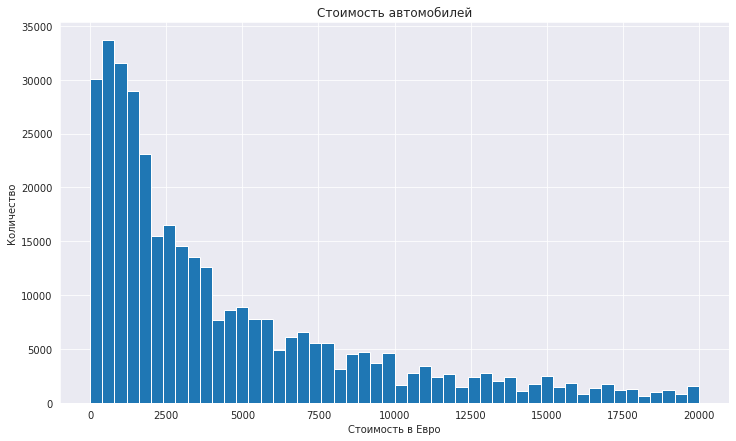

In [24]:
sns.set_style('darkgrid')
data.Price.hist(bins=50,figsize=(12,7))
plt.title('Cтоимость автомобилей')
plt.xlabel('Стоимость в Евро')
plt.ylabel('Количество')
plt.show()

<div class="alert alert-block alert-success">
<b>✔️ Комментарий ревьюера: </b> Отличный график. Есть смещение вправо. Можно сказать, что распределение логнормальное. Оно как раз хорошо описывает доходы и цены:
    
https://fin-accounting.ru/cfa/l1/quantitative/cfa-lognormal-probability-distribution
</div>


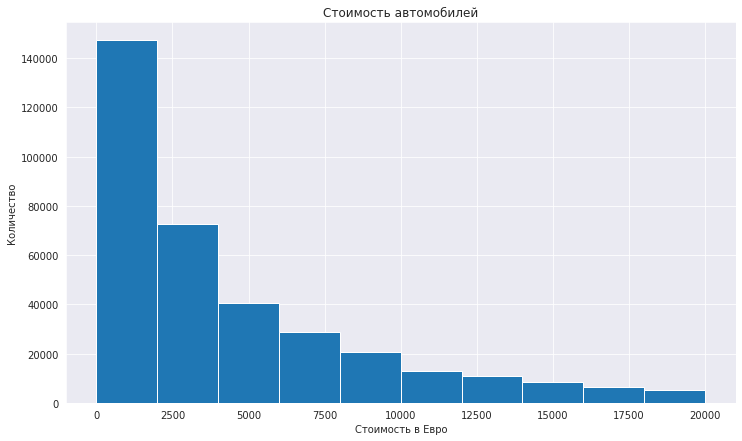

In [25]:
sns.set_style('darkgrid')
data.Price.hist(bins=10,figsize=(12,7))
plt.title('Cтоимость автомобилей')
plt.xlabel('Стоимость в Евро')
plt.ylabel('Количество')
plt.show()

<div class="alert alert-block alert-success">
<b>✔️ Комментарий ревьюера: </b> Правильно, что строишь график в разных масштабах
</div>


In [26]:
data['Price'][data['Price']==0].value_counts()

0    10772
Name: Price, dtype: int64

In [27]:
#удаляю все 0 из целевого признака
data = data.query('Price > 0')

In [28]:
data['Price'].describe()

count    343593.000000
mean       4555.147363
std        4515.076200
min           1.000000
25%        1200.000000
50%        2890.000000
75%        6500.000000
max       20000.000000
Name: Price, dtype: float64

In [29]:
#авто можно купить от 500 евро - 40 тыс рублей - удаляю выбросы
data = data.query('Price> 500')


In [30]:
data.loc[data['Price'] < 500]['Price'].count()


0

#### Год - RegistrationYear

In [31]:
#приступлю в дате
data['RegistrationYear'].describe()

count    312641.000000
mean       2004.225127
std          64.356577
min        1000.000000
25%        2000.000000
50%        2004.000000
75%        2008.000000
max        9999.000000
Name: RegistrationYear, dtype: float64

In [32]:
data=data.query('RegistrationYear >= 1950 & RegistrationYear < 2023')

In [33]:
data['RegistrationYear'].describe()

count    312489.000000
mean       2003.588674
std           7.090351
min        1950.000000
25%        2000.000000
50%        2004.000000
75%        2008.000000
max        2019.000000
Name: RegistrationYear, dtype: float64

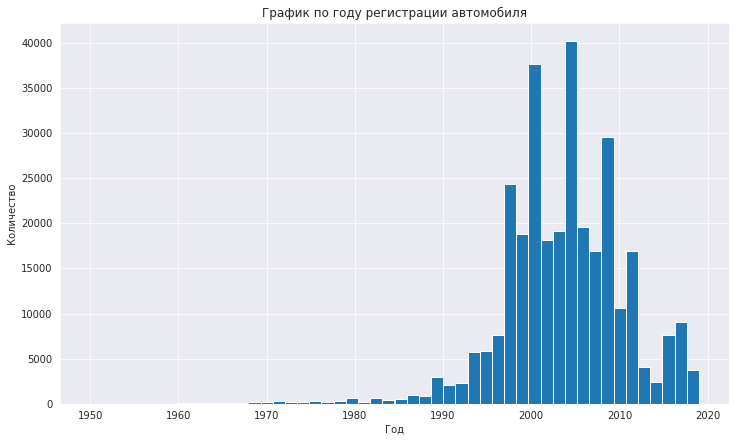

In [34]:
sns.set_style('darkgrid')
data.RegistrationYear.hist(bins=50,figsize=(12,7))
plt.title('График по году регистрации автомобиля')
plt.xlabel('Год')
plt.ylabel('Количество')
plt.show()

#### Power - мощность

In [35]:
data['Power'].describe()

count    312489.000000
mean        115.671201
std         188.907447
min           0.000000
25%          75.000000
50%         109.000000
75%         147.000000
max       20000.000000
Name: Power, dtype: float64

In [36]:
#Очевидно, что таких мощностей не бывает - удаляю
data=data.query('Power > 5 & Power < 3000')


#### Kilometer

In [37]:
data['Kilometer'].describe()

count    284738.000000
mean     127692.264468
std       36954.067772
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: Kilometer, dtype: float64

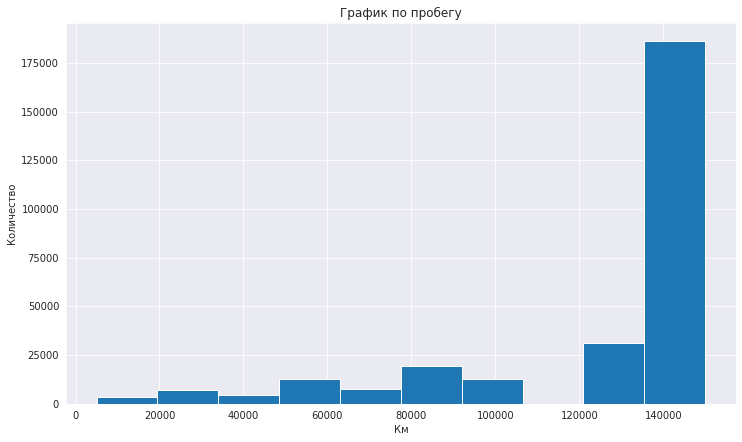

In [38]:
sns.set_style('darkgrid')
data.Kilometer.hist(bins=10,figsize=(12,7))
plt.title('График по пробегу')
plt.xlabel('Км')
plt.ylabel('Количество')
plt.show()

In [39]:
data['Kilometer'][data['Kilometer']==150000].value_counts()

150000    186010
Name: Kilometer, dtype: int64

In [40]:
#видимо, это особенности заполнения данных
data.Kilometer.value_counts()


150000    186010
125000     31272
100000     12696
90000      10264
80000       9070
70000       7845
60000       6860
50000       5715
40000       4526
30000       3862
20000       3225
5000        2490
10000        903
Name: Kilometer, dtype: int64

<div class="alert alert-block alert-success">
<b>✔️ Комментарий ревьюера: </b> Да, так
</div>


#### RegistrationMonth

In [41]:
data['RegistrationMonth'].describe()

count    284738.000000
mean          6.051655
std           3.563813
min           0.000000
25%           3.000000
50%           6.000000
75%           9.000000
max          12.000000
Name: RegistrationMonth, dtype: float64

In [42]:
#  0 - мне не подходит - заменю на ближайшее
data=data.query('RegistrationMonth >0').fillna(method='ffill')


In [43]:
data['RegistrationMonth'].unique()

array([ 5,  8,  6,  7, 10, 12, 11,  2,  3,  1,  4,  9])

#### Brand

In [44]:
#вроде все ок
data['Brand'].unique()

array(['audi', 'jeep', 'volkswagen', 'skoda', 'bmw', 'peugeot', 'ford',
       'mazda', 'nissan', 'renault', 'mercedes_benz', 'opel', 'citroen',
       'honda', 'fiat', 'mini', 'smart', 'hyundai', 'seat', 'subaru',
       'volvo', 'mitsubishi', 'alfa_romeo', 'kia', 'suzuki', 'lancia',
       'toyota', 'chevrolet', 'dacia', 'daihatsu', 'chrysler',
       'sonstige_autos', 'jaguar', 'rover', 'porsche', 'saab', 'daewoo',
       'trabant', 'land_rover', 'lada'], dtype=object)

### Красивый стиль

In [45]:
#перевожу названия в змеиный стиль
data.columns = data.columns.str.replace(r"([A-Z])", r" \1").str.lower().str.replace(' ', '_').str[1:]
data.columns

Index(['price', 'vehicle_type', 'registration_year', 'gearbox', 'power',
       'model', 'kilometer', 'registration_month', 'fuel_type', 'brand',
       'repaired'],
      dtype='object')

In [46]:
# посмотрю корреляцию

In [47]:
data\
    .corr()\
    .style\
    .background_gradient(cmap='coolwarm')

,price,registration_year,power,kilometer,registration_month
price,1.000000,0.432268,0.402108,-0.395545,0.007778
registration_year,0.432268,1.000000,0.068184,-0.282807,0.001942
power,0.402108,0.068184,1.000000,0.106272,0.018363
kilometer,-0.395545,-0.282807,0.106272,1.000000,0.009482
registration_month,0.007778,0.001942,0.018363,0.009482,1.000000


<div class="alert alert-block alert-success">
<b>✔️ Комментарий ревьюера️:</b> Да, так. Ещё можно попробовать использовать phik корреляцию. Удобно, так как покажет зависимости не только между колличественными, но и качественными признаками:
    
https://towardsdatascience.com/phik-k-get-familiar-with-the-latest-correlation-coefficient-9ba0032b37e7
</div>


In [48]:
#data

Вывод:
Удалила признаки, которые никак не влияют на цену - "DateCrawled","DateCreated","LastSeen","NumberOfPictures","PostalCode".

Заменила пропуски в признаках.

Удалила некорректные значения и выбросы в признаках. 

Удалила дубликаты - 4 шт

Проверила корреляцию: все в рамках разумных пределов, наиболее коррелирующим с целевым признаком являются признаки, отвечающие за мощность и год регистрации авто.

Привела датафрейм к единому змеиному стилю.

<div class="alert alert-block alert-success">
<b>✔️ Комментарий ревьюера:</b> Да, верно. Ещё можно использовать библиотеку pandas_profiling для автоматического построения подробных отчётов:

https://habr.com/ru/company/ruvds/blog/451478/
</div>

## Обучение моделей

In [49]:
 #Подготовлю выборки для обучения моделей

In [50]:
target = data['price'] 
#целевой
features = data.drop('price', axis=1)
#выборка
#features_train, features_valid, target_train, target_valid = train_test_split(features, 
#                                                                                  target, 
 #                                                                                 test_size=0.25, 
  #                                                                                random_state=1)
features_train, features_test, target_train, target_test = train_test_split(features,
                                                                            target, 
                                                                            test_size=.25,
                                                                            random_state=12345)

In [51]:
#Избавляемся от категориальных признаков методом Ohe
en = ['vehicle_type','gearbox', 'model', 'fuel_type', 'brand', 'repaired']
encoder = OneHotEncoder(handle_unknown ='error',drop='first')
encoder.fit(features_train[en])
data_ohe_ftrain = encoder.transform(features_train[en]).toarray()

data_ohe_ftest = encoder.transform(features_test[en]).toarray()


In [52]:
data_df_ohe = pd.DataFrame(data_ohe_ftrain, columns = encoder.get_feature_names())

data_df_ohe2 = pd.DataFrame(data_ohe_ftest, columns = encoder.get_feature_names())

In [53]:
data = data.join(data_df_ohe)

In [54]:
print(features_train.shape[0])

print(features_test.shape[0])

201902
67301


In [55]:
train_sample=features_train.shape[0]/features.shape[0]
test_sample=target_test.shape[0]/target.shape[0]

print('Размер тренировочной выборки- {:.0%}'.format(train_sample))
print('Размер тестовой выборки - {:.0%}'.format(test_sample))

Размер тренировочной выборки- 75%
Размер тестовой выборки - 25%


In [56]:
features_train.drop(en, axis = 1, inplace=True)
features_test.drop(en, axis = 1, inplace=True)

In [57]:
features_train.reset_index(drop=True, inplace=True)
features_test.reset_index(drop=True, inplace=True)

In [58]:
features_train = features_train.join(data_df_ohe)
features_test = features_test.join(data_df_ohe2)

In [59]:
features_train['x0_small'].unique()

array([1., 0.])

<div class="alert alert-block alert-danger">
<b>❌ Комментарий ревьюера:</b> Nan значения возникли после этапа кодирования признаков. Такого быть не должно. Думаю, что ошибка в join. Это из-за несоответствия индексов. Предлагаю сделать reset_index для features_train и features_test.
</div>

<div class="alert alert-block alert-success">
<b>✔️ Комментарий ревьюера v2: </b> Да, теперь верно
</div>

In [60]:
#features_train = features_train.fillna(features_train.median())
#features_test = features_test.fillna(features_test.median())

In [61]:
#features_train['x0_small'].unique()

In [62]:
#дисбаланса нет
target_train.mean(), target_test.mean()

(5283.3575695139225, 5274.646632293725)

<div class="alert alert-block alert-success">
<b>✔️ Комментарий ревьюера: </b> Дисбаланс применяется к задачам классификации. Для регрессионных задач сравнивают распределения. В данном случае предлагаю провести два статистических теста на равенство средних и равенство дисперсий:
    
https://www.codecamp.ru/blog/f-test-python/
</div>

In [63]:
#features_test

In [64]:
#данные подготовлены

In [65]:
del data_df_ohe
del data_df_ohe2
del data
del data_ohe_ftrain
del data_ohe_ftest

<div class="alert alert-block alert-success">
<b>✔️ Комментарий ревьюера v2: </b> Много лишних переменных было заведено
</div>

<div class="alert alert-block alert-success">
<b>✔️ Комментарий ревьюера: </b> Хорошо, выборки подготовлены
</div>

## Анализ моделей

### Модель LinearRegression


In [66]:
%%time

model_lr = LinearRegression()
model_lr.fit(features_train, target_train)

CPU times: user 22.2 s, sys: 22.4 s, total: 44.7 s
Wall time: 44.8 s


LinearRegression()

In [67]:
%%time

target_predict = model_lr.predict(features_train)

CPU times: user 236 ms, sys: 208 ms, total: 444 ms
Wall time: 460 ms


In [68]:
#очень плохие показатели - не нашла ошибку 
rmse_lr = mean_squared_error(target_train, target_predict) ** .5
rmse_lr

2705.828069348864

<div class="alert alert-block alert-success">
<b>✔️ Комментарий ревьюера️: </b> Для линейной регрессии нормальный результат
</div>

In [69]:
# C использованием кроссвалидации
cvs_rmse_lr = (cross_val_score(model_lr,
                               features_train,
                               target_train,
                               cv=5,
                               scoring='neg_mean_squared_error')).mean() * -1 ** .5
cvs_rmse_lr

7353682.6895138975

### CatBoostRegressor


In [70]:
%%time

model_cbr = CatBoostRegressor(learning_rate=.5, random_state=12345, verbose=False) 
model_cbr.fit(features_train, target_train)

CPU times: user 27.7 s, sys: 879 ms, total: 28.6 s
Wall time: 29.9 s


<div class="alert alert-block alert-warning">
<b>⚠️ Комментарий ревьюера: </b> 
Catboost может обрабатывать категориальные признаки напрямую, внутри модели. 
Для этого он использует более продвинутые механизмы, поэтому для него кодировать признаки не нужно:

https://catboost.ai/en/docs/features/categorical-features

https://towardsdatascience.com/how-catboost-encodes-categorical-variables-3866fb2ae640

https://www.kaggle.com/code/kgxiao/comparison-of-catboost-and-one-hot-encoding
</div>

In [71]:
%%time

model_cbr = CatBoostRegressor(learning_rate=.1, random_state=12345, verbose=False) 
model_cbr.fit(features_train, target_train)

CPU times: user 27.2 s, sys: 675 ms, total: 27.8 s
Wall time: 29 s


In [72]:
%%time

model_cbr = CatBoostRegressor(learning_rate=.8, random_state=12345, verbose=False) 
model_cbr.fit(features_train, target_train)

CPU times: user 28.6 s, sys: 647 ms, total: 29.3 s
Wall time: 30.9 s


In [73]:
target_predict = model_cbr.predict(features_train)


In [74]:
rmse_cbr=mean_squared_error(target_train, target_predict) ** .5
rmse_cbr

1304.714622784368

<div class="alert alert-block alert-warning">
<b>⚠️ Комментарий ревьюера: </b>  RMSE можно посчитать, задав параметр squared=False у функции mean_squared_error
</div>

### LightGBM

In [75]:
#%%time

#model_lgbm = LGBMRegressor() 
#parameters = [{'num_leaves':[25, 50, 100, 200], 'learning_rate':[.1, .3, .5], 'random_state':[12345]}]

#clf = GridSearchCV(model_lgbm, parameters, scoring='neg_mean_squared_error')
#clf.fit(features_train, target_train)

#print(clf.best_params_)
#print()

#mts= clf.cv_results_['mean_test_score']

#rmse_lgbm = (max(mts) * -1) ** .5
#rmse_lgbm

In [76]:
#это было оооооочень долго

In [ ]:
%%time

model_lgbmr = LGBMRegressor(learning_rate=.5, num_leaves=200, random_state=12345)
model_lgbmr.fit(features_train, target_train)

<div class="alert alert-block alert-warning">
<b>⚠️ Комментарий ревьюера: </b> 
Модель LGBM может обрабатывать категориальные признаки напрямую, внутри модели.
Для этого необходимо закодировать категориальные колонки astype('category').

Кодирование LGBM похоже на OrdinalEncoder, но выполняется немного сложнее. Это делает предсказания точнее.

https://lightgbm.readthedocs.io/en/latest/Advanced-Topics.html#categorical-feature-support
</div>

In [ ]:
%%time

target_predict = model_lgbmr.predict(features_train)

In [ ]:
rmse_lgbmr = mean_squared_error(target_train, target_predict) ** .5
rmse_lgbmr

## Выбор лучшей модели и ее тестирование

In [ ]:
#создаю сводную таблицу по показателям RMSE < 2500, время обучения модели и время предсказания модели:
index = ['Линейная регрессия',
         'CatBoostRegressor',
         'LGBMRegressor'
        ]

data = {'RMSE':[rmse_lr,
                rmse_cbr,
                rmse_lgbmr]
       }
        
        

all_data = pd.DataFrame(data=data, index=index)

all_data


#выбираем модель LGBMRegressor

In [ ]:
%%time

#проверяю качество модели на тестовой выборке:
model_lgbmr_test = LGBMRegressor(learning_rate=.5, num_leaves=200, random_state=12345)
model_lgbmr_test.fit(features_train, target_train)

In [ ]:
target_predict = model_lgbmr_test.predict(features_test)


In [ ]:
#на тестовой выборке показатели хуже, модель переобучилась?
rmse_lgbmr_test = mean_squared_error(target_test, target_predict) ** .5
rmse_lgbmr_test

<div class="alert alert-block alert-success">
<b>✔️ Комментарий ревьюера: </b> Да, немного переобучилась. Бустинги к этому склонны.
</div>

Вывод:
Наилучшей моделью стала LGBMRegressor с OHE, которая на финальном тестировании показала RMSE 1586

## Общий вывод


Передо мной стояла задача- построить модель для определения стоимости автомобиля, с лучшими показателями качества предсказания.

Я  использовала технологию градиетного бустинга в моделях CatBoostRegressor и LightGBM и сравнила её с базовыми моделями LinearRegression

По итогам качества и скорости обучения на тестовых данных - с небольшим отрывом  побеждает модель LightGBM.

Таким образом, для компании "Не бит, не крашен" могу  рекомендовать модель LightGBM

<font color='blue'><b>Итоговый комментарий ревьюера</b></font>
<div class="alert alert-block alert-success">
<b>✔️ Комментарий ревьюера:</b>
Мне понравилась твоя работа. Спасибо тебе большое, за хорошее оформление проекта и выводы к каждому этапу работы.
Чувствуется уверенное знание материала и владение питоном в целом. 
</div>
<font color='blue'><b>Но нужно кое-что поправить:</b></font>
<div class="alert alert-block alert-danger">
<ul>1) Поправить кодирование признаков</ul>
</div>

<font color='blue'><b>Осталось совсем немного, буду ждать твою работу на повторное ревью 🙂</b></font>

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Выполнена загрузка и подготовка данных
- [ ]  Выполнено обучение моделей
- [ ]  Есть анализ скорости работы и качества моделей

:)